In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import os
import json
import shutil
import random
from pathlib import Path
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from tqdm import tqdm
from urllib.parse import urlparse
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import shutil
import os
from mtrain.smallnet.unet.extract import generate_dataset
from fastai.vision.all import resnet18, mobilenet_v3_large, mobilenet_v3_small
from mtrain.smallnet.unet.train import get_dls
from fastai.vision.all import unet_learner, ProgressCallback, CSVLogger


In [35]:
from mtrain.experiment import (
    run_experiments,
    cartesian_dict,
    NestedProjectDirsGetter,
    prepare_experiment_cfg,
)

In [50]:
NAME = "s013-mobilenet-unet-compare"

DS = Path("/Users/hariomnarang/Desktop/personal/roads/datasets")
EXP_ROOT = DS / NAME
EXP_ROOT.mkdir(parents=True, exist_ok=True)
dir_getter = NestedProjectDirsGetter(EXP_ROOT)

EXP_CONF = {
    "DATA_COUNT": ["2000"],
    "TILE_SIZE": ["30", "50", "100"],
    "BATCH_SIZE": ["2"],
    "FINE_TUNE_EPOCHS": ["15"],
    "FIT_EPOCHS": ["15"],
    "MODEL": ["mobilenet_v3_small", "mobilenet_v3_large"],
}
EXPERIMENTS = cartesian_dict(EXP_CONF)
EXTRA_ENV = {
    "TACO_DIR": "/Users/hariomnarang/Desktop/personal/TACO/data",
}
# EXP_CFGS = [
#     prepare_experiment_cfg(NAME, cfg, dir_getter, EXTRA_ENV)[0] for cfg in EXPERIMENTS
# ]


In [51]:
run_experiments(NAME, EXPERIMENTS, ["uv", "run", "../scripts/colab/train_unet.py"], dir_getter, EXTRA_ENV)


🚀 Running [s013-mobilenet-unet-compare-DATA_COUNT=2000-TILE_SIZE=30-BATCH_SIZE=2-FINE_TUNE_EPOCHS=15-FIT_EPOCHS=15-MODEL=mobilenet_v3_small] (attempt 1/1)
log file: /Users/hariomnarang/Desktop/personal/roads/datasets/s013-mobilenet-unet-compare/s013-mobilenet-unet-compare-DATA_COUNT=2000-TILE_SIZE=30-BATCH_SIZE=2-FINE_TUNE_EPOCHS=15-FIT_EPOCHS=15-MODEL=mobilenet_v3_small/logs/20260130_114804_s013-mobilenet-unet-compare-DATA_COUNT=2000-TILE_SIZE=30-BATCH_SIZE=2-FINE_TUNE_EPOCHS=15-FIT_EPOCHS=15-MODEL=mobilenet_v3_small.log
running command:  DATA_COUNT='2000' TILE_SIZE='30' BATCH_SIZE='2' FINE_TUNE_EPOCHS='15' FIT_EPOCHS='15' MODEL='mobilenet_v3_small' name='s013-mobilenet-unet-compare-DATA_COUNT=2000-TILE_SIZE=30-BATCH_SIZE=2-FINE_TUNE_EPOCHS=15-FIT_EPOCHS=15-MODEL=mobilenet_v3_small' PROJECT_CODE='s013-mobilenet-unet-compare-DATA_COUNT=2000-TILE_SIZE=30-BATCH_SIZE=2-FINE_TUNE_EPOCHS=15-FIT_EPOCHS=15-MODEL=mobilenet_v3_small' TACO_DIR='/Users/hariomnarang/Desktop/personal/TACO/data' PR

KeyboardInterrupt: 

In [27]:
idx = 0

cfg = EXP_CFGS[idx]
BATCH_SIZE = int(cfg["BATCH_SIZE"])
PROJECT_WORK_DIR = Path(cfg["PROJECT_WORK_DIR"])
PROJECT_PERM_DIR = Path(cfg["PROJECT_PERM_DIR"])
TACO_DIR = Path(cfg["TACO_DIR"])
PROJECT_CODE = cfg["PROJECT_CODE"]
MODEL = cfg["MODEL"]
TILE_SIZE = int(cfg["TILE_SIZE"])
DATA_COUNT = int(cfg["DATA_COUNT"])

ANN_FILE = TACO_DIR / "annotations.json"
LOG_BASE = PROJECT_PERM_DIR / "log"
DATA_DIR = PROJECT_WORK_DIR / "data"

LOG_BASE.mkdir(exist_ok=True, parents=True)

In [25]:
generate_dataset(
    ann_file=ANN_FILE,
    taco_dir=TACO_DIR,
    output_path=DATA_DIR,
    tile_size=TILE_SIZE,
    num_samples=DATA_COUNT,
    workers=16,
)

CACHE HIT: will copy to /Users/hariomnarang/.mtrain_synth_cache/generate_dataset_f9ae0037ad70eab1 -> /Users/hariomnarang/Desktop/personal/roads/datasets/s013-mobilenet-unet-compare/s013-mobilenet-unet-compare-DATA_COUNT=2000-TILE_SIZE=30-BATCH_SIZE=2-FINE_TUNE_EPOCHS=10-FIT_EPOCHS=5-MODEL=mobilenet_v3_small/work/data
Copy: /Users/hariomnarang/.mtrain_synth_cache/generate_dataset_f9ae0037ad70eab1 /Users/hariomnarang/Desktop/personal/roads/datasets/s013-mobilenet-unet-compare/s013-mobilenet-unet-compare-DATA_COUNT=2000-TILE_SIZE=30-BATCH_SIZE=2-FINE_TUNE_EPOCHS=10-FIT_EPOCHS=5-MODEL=mobilenet_v3_small/work/data
copied files: 422 to /Users/hariomnarang/Desktop/personal/roads/datasets/s013-mobilenet-unet-compare/s013-mobilenet-unet-compare-DATA_COUNT=2000-TILE_SIZE=30-BATCH_SIZE=2-FINE_TUNE_EPOCHS=10-FIT_EPOCHS=5-MODEL=mobilenet_v3_small/work/data


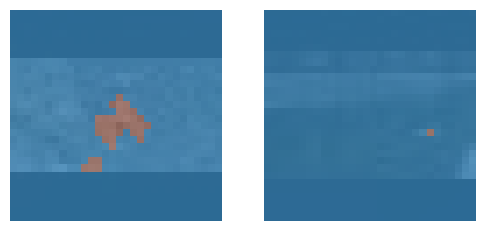

In [29]:
dls = get_dls(BATCH_SIZE, LOG_BASE, TILE_SIZE, DATA_DIR / "images", DATA_DIR / "masks")
dls.train.show_batch(max_n=4, nrows=1, alpha=0.7)
show_batch_path = LOG_BASE / "show_batch.png"
plt.savefig(show_batch_path, bbox_inches="tight", dpi=200)
plt.show()
plt.close()

In [32]:
model_by_cls = {
    "resnet18": resnet18,
    "mobilenet_v3_small": mobilenet_v3_small,
    "mobilenet_v3_large": mobilenet_v3_large,
}

learner = unet_learner(dls, model_by_cls[MODEL])
learner.remove_cb(ProgressCallback)
learner = learner.add_cb(CSVLogger)

/Users/hariomnarang/Desktop/personal/roads/mtrain/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hariomnarang/Desktop/personal/roads/mtrain/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
learner.fine_tune(10)

[0, 0.3597925901412964, 0.526957631111145, '00:21']
[0, 0.22334299981594086, 0.4553827941417694, '00:20']
[1, 0.2556731104850769, 0.4677063226699829, '00:21']
[2, 0.2794401943683624, 0.3874596655368805, '00:20']


KeyboardInterrupt: 